In [1]:
def starr_domain(outcome_list, criterion):
    total_scenarios = len(outcome_list)
    met_scenarios = 0
    for outcome in outcome_list:
        #outcomes are minimized - less is more :)
        if outcome < criterion:
            met_scenarios += 1
            
    return met_scenarios/total_scenarios

import statistics

def undesirable_dev(outcome_list):
    outcome_list.sort()
    median = statistics.median(outcome_list)

    
    undesirable_sum = 0
    
    #all the outcomes are minimized (incl. effectiveness if you leave it in it's original negative state)
    #so the worst outcomes are in the second half of the list
    for i in range(int(len(outcome_list)/2),len(outcome_list)):
        undesirable_sum += outcome_list[i] - median
        
    return undesirable_sum
    

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench.util import load_results, merge_results
results1 = load_results(r'policy141_10000.tar.gz')
results2 = load_results(r'policy148_390_10000.tar.gz')
results3 = load_results(r'policy185_661_10000.tar.gz')

In [3]:
results4 = merge_results(results1, results2)
results = merge_results(results3, results4)

experiments, outcomes = results


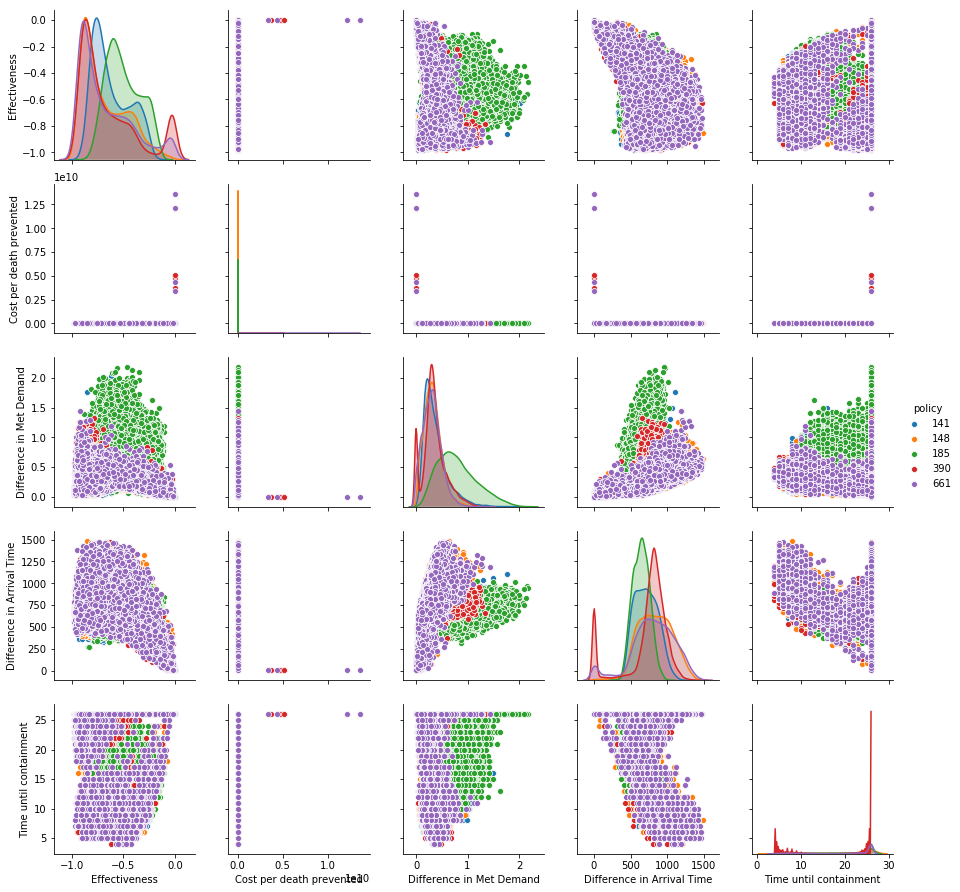

In [4]:


outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

#outcomes['Effectiveness'] = [ -x for x in outcomes['Effectiveness']]

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

### Calculating the values for Undesirable Deviations Robustness Measure ###

In [5]:
policy_141 = data[data['policy'] == 141]
policy_148 = data[data['policy'] == 148]
policy_390 = data[data['policy'] == 390]
policy_185 = data[data['policy'] == 185]
policy_661 = data[data['policy'] == 661]


We want to compare these policies to the all-exploitative policy, so we need to load in data for that as well

In [6]:
experiments, outcomes = load_results(r'all_exploitation_10000_1.tar.gz')

outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

#need to change signs on these values as this was run on a model that did not minimize
outcomes['Effectiveness'] = [ -x for x in outcomes['Effectiveness']]

policy_exploit = pd.DataFrame.from_dict(outcomes)

In [7]:


und_dev_141 = [141]

for col in policy_141:
    if col != 'policy':
        dev = undesirable_dev(policy_141[col].to_list())
        und_dev_141.append(dev)
        
und_dev_148 = [148]

for col in policy_148:
    if col != 'policy':
        dev = undesirable_dev(policy_148[col].to_list())
        und_dev_148.append(dev)

und_dev_390 = [390]

for col in policy_390:
    if col != 'policy':
        dev = undesirable_dev(policy_390[col].to_list())
        und_dev_390.append(dev)
        
und_dev_185 = [185]

for col in policy_185:
    if col != 'policy':
        dev = undesirable_dev(policy_185[col].to_list())
        und_dev_185.append(dev)
        
und_dev_661 = [661]

for col in policy_661:
    if col != 'policy':
        dev = undesirable_dev(policy_661[col].to_list())
        und_dev_661.append(dev)
        
und_dev_exploit = ['exploit']

for col in policy_exploit:
    if col != 'policy':
        dev = undesirable_dev(policy_exploit[col].to_list())
        und_dev_exploit.append(dev)

und_dev_scores = pd.DataFrame(np.array([und_dev_141, und_dev_148, und_dev_390, und_dev_185, und_dev_661, und_dev_exploit]),
                    columns=['Policy','Robustness in Effectiveness', 'Robustness in Cost per death prevented',
                             'Robustness in Difference in Demand Met', 'Robustness in Difference in Arrival Time',
                            'Robustness in Time until containment'])

und_dev_scores

,Policy,Robustness in Effectiveness,Robustness in Cost per death prevented,Robustness in Difference in Demand Met,Robustness in Difference in Arrival Time,Robustness in Time until containment
0,141,996.4475306490934,32918156.638801694,1133.4071225296339,687925.875,0.0
1,148,1232.7224782635562,27070936.5513211,736.7651424719811,947115.25,0.0
2,390,1612.5015467142957,18613724574.429268,933.8202278605135,562385.875,0.0
3,185,816.8806134656886,76304578.16115399,1781.8055051564554,460935.5,0.0
4,661,1456.718201050259,33542290801.700546,741.813891766783,1080102.25,0.0
5,exploit,1680.4280691487465,18735955.561972115,781.0660643527983,1115861.6875,0.0


These values are pretty wild and hard to compare - so let's normalize them. This is fine because it's a relative robustness measure.

In [8]:
from sklearn import preprocessing

df = und_dev_scores[['Robustness in Effectiveness', 'Robustness in Cost per death prevented',
                    'Robustness in Difference in Demand Met', 'Robustness in Difference in Arrival Time']]



# Create x, where x the 'scores' column's values as floats
x = df.values

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)



und_dev_scores['Robustness in Effectiveness'] = df_normalized[0]
und_dev_scores['Robustness in Cost per death prevented'] = df_normalized[1]
und_dev_scores['Robustness in Difference in Demand Met'] = df_normalized[2]
und_dev_scores['Robustness in Difference in Arrival Time'] = df_normalized[3]

und_dev_scores

C:\Users\Emma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Policy,Robustness in Effectiveness,Robustness in Cost per death prevented,Robustness in Difference in Demand Met,Robustness in Difference in Arrival Time,Robustness in Time until containment
0,141,0.207941,0.000423,0.379547,0.346589,0.0
1,148,0.481551,0.000249,0.000000,0.742343,0.0
2,390,0.921340,0.554684,0.188562,0.154904,0.0
3,185,0.000000,0.001717,1.000000,0.000000,0.0
4,661,0.740941,1.000000,0.004831,0.945399,0.0
5,exploit,1.000000,0.000000,0.042392,1.000000,0.0


In [9]:
und_dev_scores['policy_number'] = [0,0.2,0.4,0.6,0.8,1]


In [10]:

import plotly
import plotly.graph_objs as go

import pandas as pd 

plotly.offline.init_notebook_mode(connected=True)

data = [
    go.Parcoords(
        line = dict(color = und_dev_scores['policy_number'],
                   colorscale = [[0, '#6C9E12'], 
                                [0.2,'#0D5F67'], 
                                [0.4,'#7e2e2e'], 
                                [0.6, '#69178C'], 
                                [0.8, '#DE9733'],
                                [1,'#ff0000']]),  #
        dimensions = list([
            dict(range = [0,1],
                label = 'Effectiveness', values = und_dev_scores['Robustness in Effectiveness']),
            dict(range = [0,1],
                label = 'Cost', values = und_dev_scores['Robustness in Cost per death prevented']),
            dict(range = [0,1],
                label = 'Met demand', values = und_dev_scores['Robustness in Difference in Demand Met']),
            dict(range = [0,1],
                label = 'Arrival Time', values = und_dev_scores['Robustness in Difference in Arrival Time'])
        ])
    )
]



fig = go.Figure(data = data)
plotly.offline.iplot(fig, filename = 'parcoords-basic')

### Calculating Starr Domain ###

What do we use as a criterion value? First, let's try the median value of the all-exploitation policy, the new policies should then score better than 0.5!

In [44]:
st_dom_141 = [141]

for col in policy_141:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_141[col].to_list(), 25)
        else:
            st = starr_domain(policy_141[col].to_list(), policy_exploit[col].median())
        st_dom_141.append(st)
        
st_dom_148 = [148]

for col in policy_148:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_148[col].to_list(), 25)
        else:
            st = starr_domain(policy_148[col].to_list(), policy_exploit[col].median())
        st_dom_148.append(st)
        
st_dom_390 = [390]

for col in policy_390:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_390[col].to_list(), 25)
        else:
            st = starr_domain(policy_390[col].to_list(), policy_exploit[col].median())
        st_dom_390.append(st)
        
st_dom_185 = [185]

for col in policy_185:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_185[col].to_list(), 25)
        else:
            st = starr_domain(policy_185[col].to_list(), policy_exploit[col].median())
        st_dom_185.append(st)
        
st_dom_661 = [661]

for col in policy_661:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_661[col].to_list(), 25)
        else:
            st = starr_domain(policy_661[col].to_list(), policy_exploit[col].median())
        st_dom_661.append(st)
        
st_dom_exploit = ['exploit']

for col in policy_exploit:
    if col != 'policy':
        if col == 'Time until containment':
            st = starr_domain(policy_exploit[col].to_list(), 25)
        else:
            st = starr_domain(policy_exploit[col].to_list(), policy_exploit[col].median())
        
        st_dom_exploit.append(st)
        
st_dom_scores = pd.DataFrame(np.array([st_dom_141, st_dom_148, st_dom_390, st_dom_185, st_dom_661, st_dom_exploit]),
                    columns=['Policy','Robustness in Effectiveness', 'Robustness in Cost per death prevented',
                             'Robustness in Difference in Demand Met', 'Robustness in Difference in Arrival Time',
                            'Robustness in Time until containment'])

st_dom_scores

,Policy,Robustness in Effectiveness,Robustness in Cost per death prevented,Robustness in Difference in Demand Met,Robustness in Difference in Arrival Time,Robustness in Time until containment
0,141,0.2576,0.2501,0.4191,0.7016,0.3284
1,148,0.3704,0.4871,0.4209,0.4634,0.4249
2,390,0.4561,0.4939,0.3595,0.4886,0.1892
3,185,0.0984,0.0232,0.051,0.9268,0.4474
4,661,0.3943,0.4983,0.4484,0.4783,0.3704
5,exploit,0.5,0.5,0.5,0.4997,0.3141


In [45]:
st_dom_scores['policy_number'] = [0,0.2,0.4,0.6,0.8,1]

In [46]:

import pandas as pd 

plotly.offline.init_notebook_mode(connected=True)

data = [
    go.Parcoords(
        line = dict(color = st_dom_scores['policy_number'],
                   colorscale = [[0, '#6C9E12'], 
                                [0.2,'#0D5F67'], 
                                [0.4,'#7e2e2e'], 
                                [0.6, '#69178C'], 
                                [0.8, '#DE9733'],
                                [1,'#ff0000']]),  #
        dimensions = list([
            dict(range = [0,1],
                label = 'Effectiveness', values = st_dom_scores['Robustness in Effectiveness']),
            dict(range = [0,1],
                label = 'Cost', values = st_dom_scores['Robustness in Cost per death prevented']),
            dict(range = [0,1],
                label = 'Met demand', values = st_dom_scores['Robustness in Difference in Demand Met']),
            dict(range = [0,1],
                label = 'Arrival Time', values = st_dom_scores['Robustness in Difference in Arrival Time'])
        ])
    )
]



fig = go.Figure(data = data)
plotly.offline.iplot(fig, filename = 'parcoords-basic')

### Pairplots for all the policies seperately ###
We have to reload the data loading because we now need to change the sign for effectiveness to make the scatterplot more intuitive

In [1]:
from ema_workbench.util import load_results, merge_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results1 = load_results(r'policy141_10000.tar.gz')
results2 = load_results(r'policy148_390_10000.tar.gz')
results3 = load_results(r'policy185_661_10000.tar.gz')

results4 = merge_results(results1, results2)
results = merge_results(results3, results4)

experiments, outcomes = results

outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

outcomes['Effectiveness'] = [ -x for x in outcomes['Effectiveness']]

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies


policy_141 = data[data['policy'] == 141]
policy_148 = data[data['policy'] == 148]
policy_390 = data[data['policy'] == 390]
policy_185 = data[data['policy'] == 185]
policy_661 = data[data['policy'] == 661]

C:\Users\Emma\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
experiments, outcomes = load_results(r'all_exploitation_10000_1.tar.gz')

outcomes['Difference in Met Demand'] = outcomes.pop('Equity in met demand')
outcomes['Difference in Arrival Time'] = outcomes.pop('Equity in arrival times')
outcomes['Time until containment'] = outcomes.pop('Speed')

all_exploitation = pd.DataFrame.from_dict(outcomes)


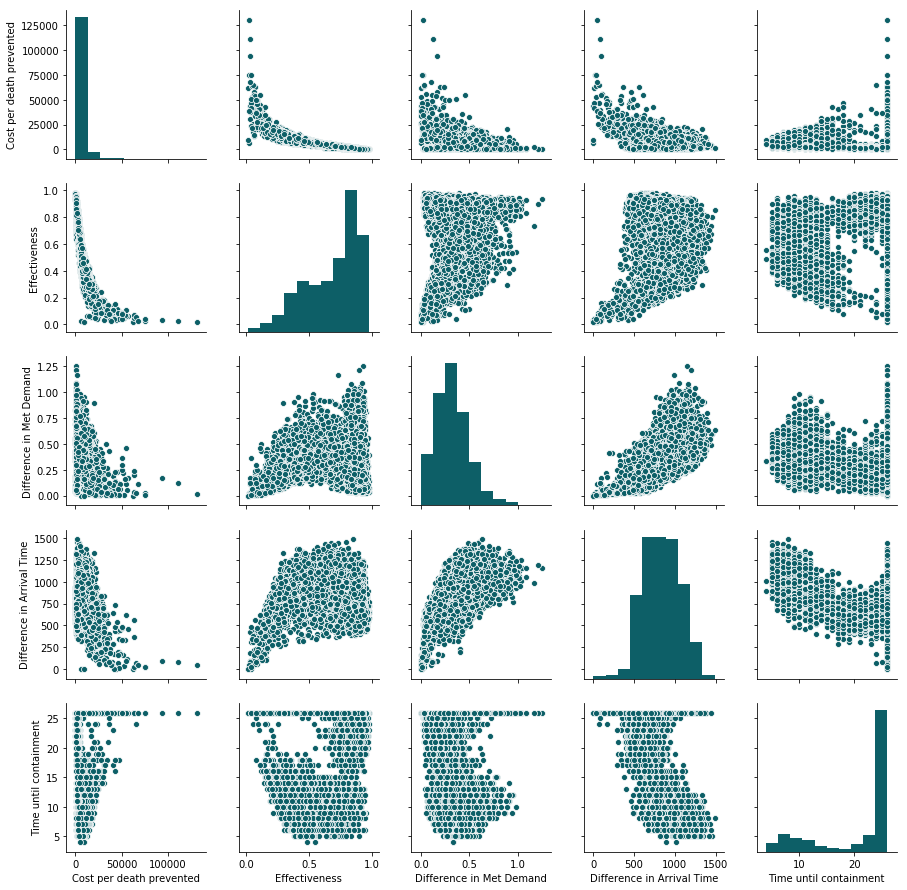

In [3]:
sns.pairplot(policy_148.drop(labels=['policy'], axis=1), plot_kws=dict(color='#0D5F67'), diag_kws=dict(color='#0D5F67'))
plt.show()

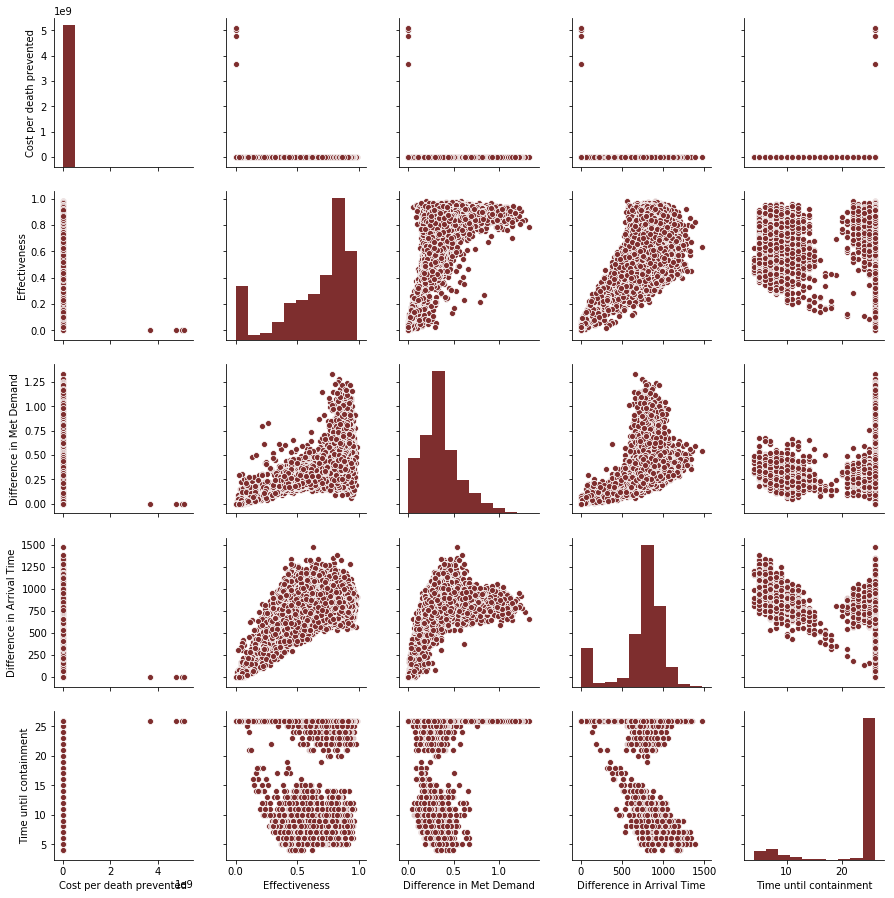

In [4]:
sns.pairplot(policy_390.drop(labels=['policy'], axis=1), plot_kws=dict(color='#7e2e2e'), diag_kws=dict(color='#7e2e2e'))
plt.show()

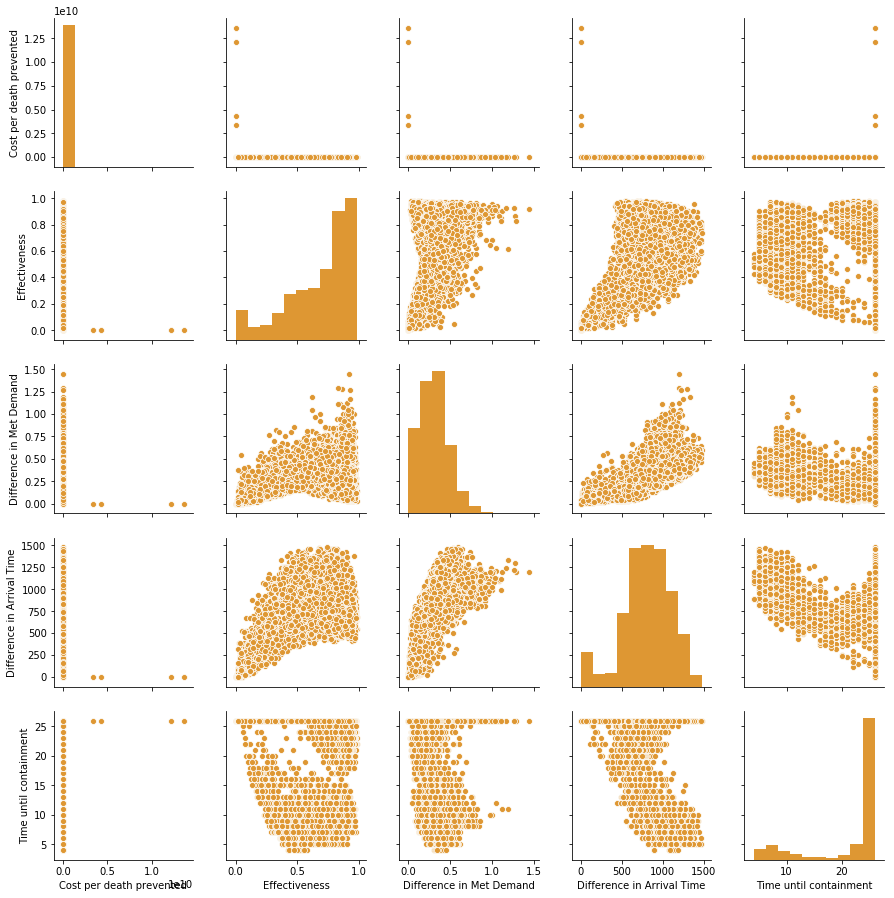

In [6]:
sns.pairplot(policy_661.drop(labels=['policy'], axis=1), plot_kws=dict(color='#DE9733'), diag_kws=dict(color='#DE9733'))
plt.show()

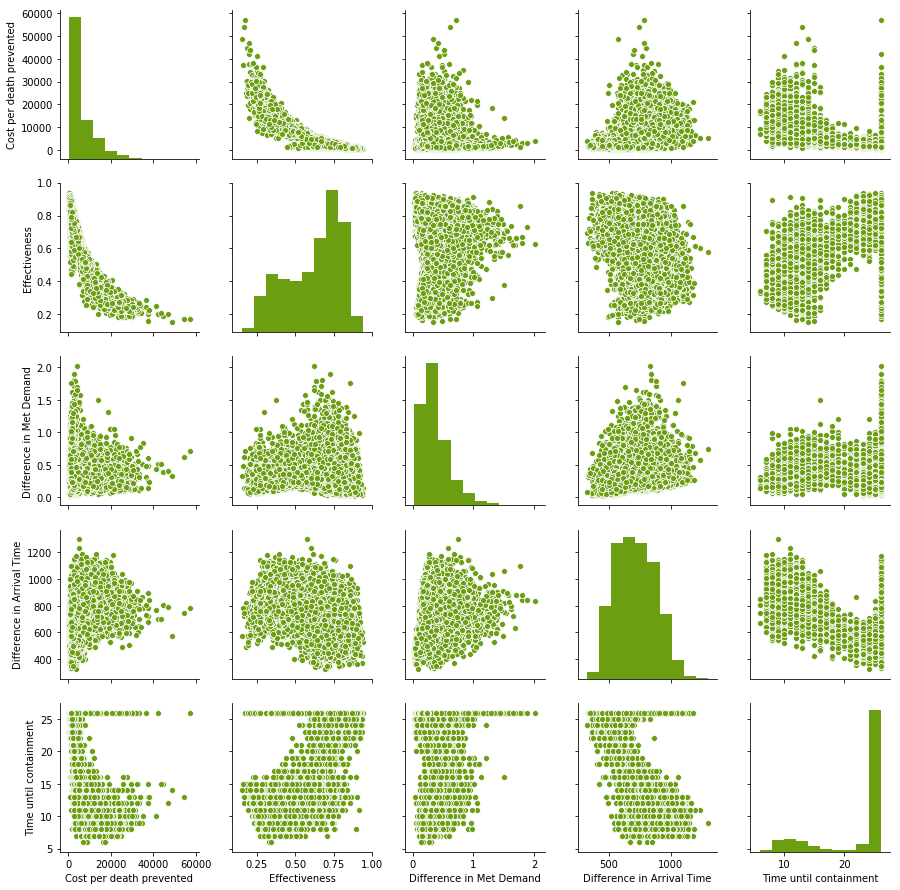

In [7]:
sns.pairplot(policy_141.drop(labels=['policy'], axis=1), plot_kws=dict(color='#6C9E12'), diag_kws=dict(color='#6C9E12'))
plt.show()

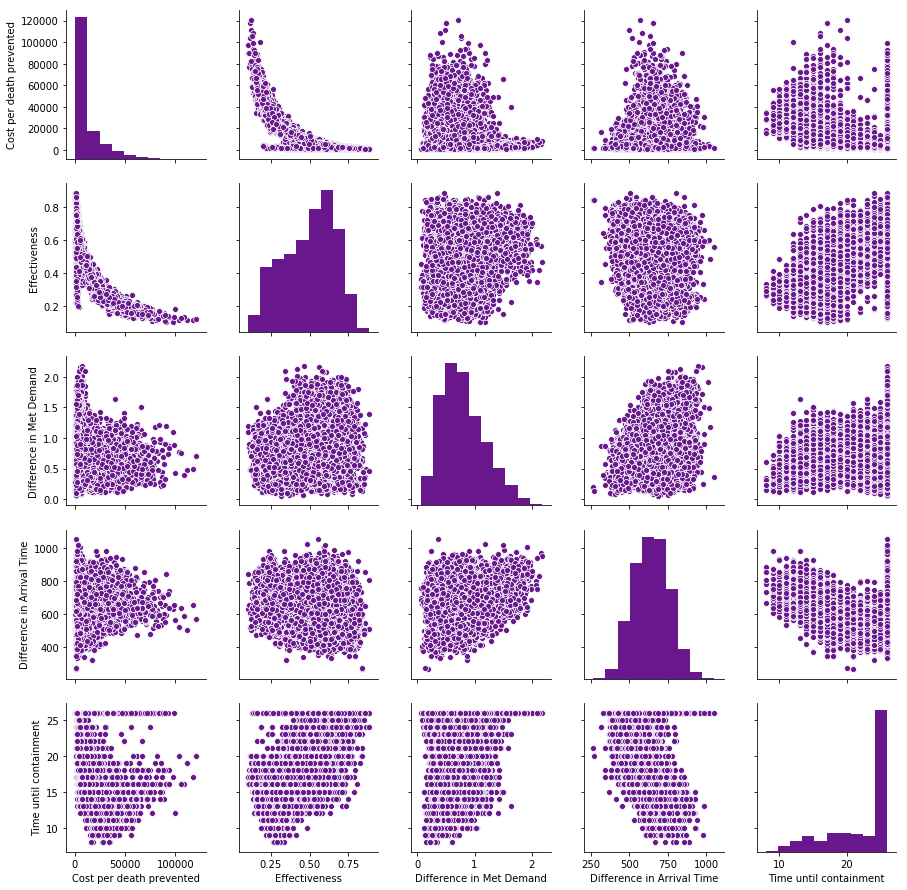

In [8]:
sns.pairplot(policy_185.drop(labels=['policy'], axis=1), plot_kws=dict(color='#69178C'), diag_kws=dict(color='#69178C'))
plt.show()

The two exploitative policies have some extreme outliers - if we want to study their distribution at normal values in order to compare them to the other policies we have to remove them

In [11]:
cost_390 = policy_390['Cost per death prevented']
cost_390 = cost_390.sort_values()


cost_661 = policy_661['Cost per death prevented']
cost_661 = cost_661.sort_values()


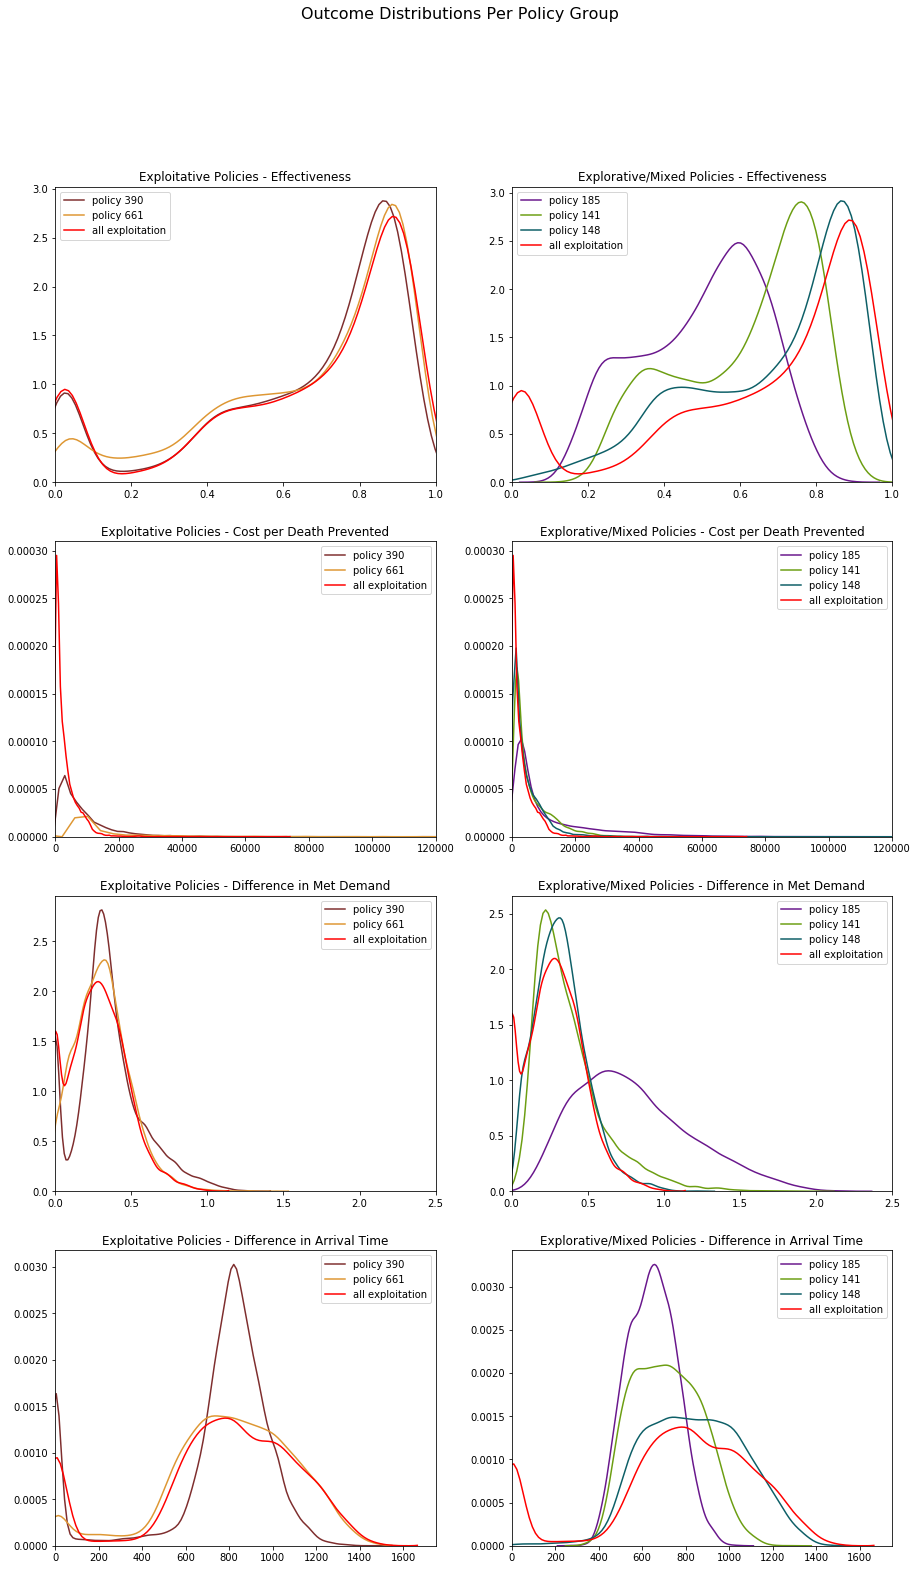

In [22]:
plt.figure(figsize=(15,25))

plt.subplot(421)

sns.kdeplot(policy_390['Effectiveness'], label="policy 390" , color='#7e2e2e')
sns.kdeplot(policy_661['Effectiveness'], label="policy 661", color='#DE9733')
sns.kdeplot(all_exploitation['Effectiveness'], label="all exploitation", color='r')
plt.xlim([0,1])
plt.title('Exploitative Policies - Effectiveness')

plt.subplot(422)

sns.kdeplot(policy_185['Effectiveness'], label="policy 185", color='#69178C')
sns.kdeplot(policy_141['Effectiveness'], label="policy 141", color='#6C9E12')
sns.kdeplot(policy_148['Effectiveness'], label="policy 148", color='#0D5F67')
sns.kdeplot(all_exploitation['Effectiveness'], label="all exploitation", color='r')
plt.xlim([0,1])
plt.title('Explorative/Mixed Policies - Effectiveness')


plt.subplot(423)


sns.kdeplot(cost_390[:-4],  label="policy 390", color='#7e2e2e')
sns.kdeplot(cost_661[:-4],  label="policy 661", color='#DE9733')
sns.kdeplot(all_exploitation['Cost per death prevented'], label="all exploitation", color='r')
plt.xlim(0,120000)


plt.title('Exploitative Policies - Cost per Death Prevented')

plt.subplot(424)

sns.kdeplot(policy_185['Cost per death prevented'], label="policy 185" , color='#69178C')
sns.kdeplot(policy_141['Cost per death prevented'], label="policy 141", color='#6C9E12')
sns.kdeplot(policy_148['Cost per death prevented'], label="policy 148", color='#0D5F67')
sns.kdeplot(all_exploitation['Cost per death prevented'], label="all exploitation", color ='r')
plt.xlim(0,120000)

plt.title('Explorative/Mixed Policies - Cost per Death Prevented')



plt.subplot(425)

sns.kdeplot(policy_390['Difference in Met Demand'], label="policy 390", color='#7e2e2e')
sns.kdeplot(policy_661['Difference in Met Demand'], label="policy 661", color='#DE9733')
sns.kdeplot(all_exploitation['Difference in Met Demand'], label="all exploitation", color='r')
plt.xlim([0,2.5])
plt.title('Exploitative Policies - Difference in Met Demand')

plt.subplot(426)

sns.kdeplot(policy_185['Difference in Met Demand'], label="policy 185", color='#69178C')
sns.kdeplot(policy_141['Difference in Met Demand'], label="policy 141", color='#6C9E12')
sns.kdeplot(policy_148['Difference in Met Demand'], label="policy 148", color='#0D5F67')
sns.kdeplot(all_exploitation['Difference in Met Demand'], label="all exploitation", color='r')
plt.xlim([0,2.5])
plt.title('Explorative/Mixed Policies - Difference in Met Demand')


plt.subplot(427)

sns.kdeplot(policy_390['Difference in Arrival Time'], label="policy 390", color='#7e2e2e')
sns.kdeplot(policy_661['Difference in Arrival Time'], label="policy 661", color='#DE9733')
sns.kdeplot(all_exploitation['Difference in Arrival Time'], label="all exploitation", color='r')
plt.xlim([0,1750])
plt.title('Exploitative Policies - Difference in Arrival Time')

plt.subplot(428)

sns.kdeplot(policy_185['Difference in Arrival Time'], label="policy 185", color='#69178C')
sns.kdeplot(policy_141['Difference in Arrival Time'], label="policy 141", color='#6C9E12')
sns.kdeplot(policy_148['Difference in Arrival Time'], label="policy 148", color='#0D5F67')
sns.kdeplot(all_exploitation['Difference in Arrival Time'], label="all exploitation", color='r')
plt.xlim([0,1750])
plt.title('Explorative/Mixed Policies - Difference in Arrival Time')


plt.suptitle('Outcome Distributions Per Policy Group',size=16)
plt.show()

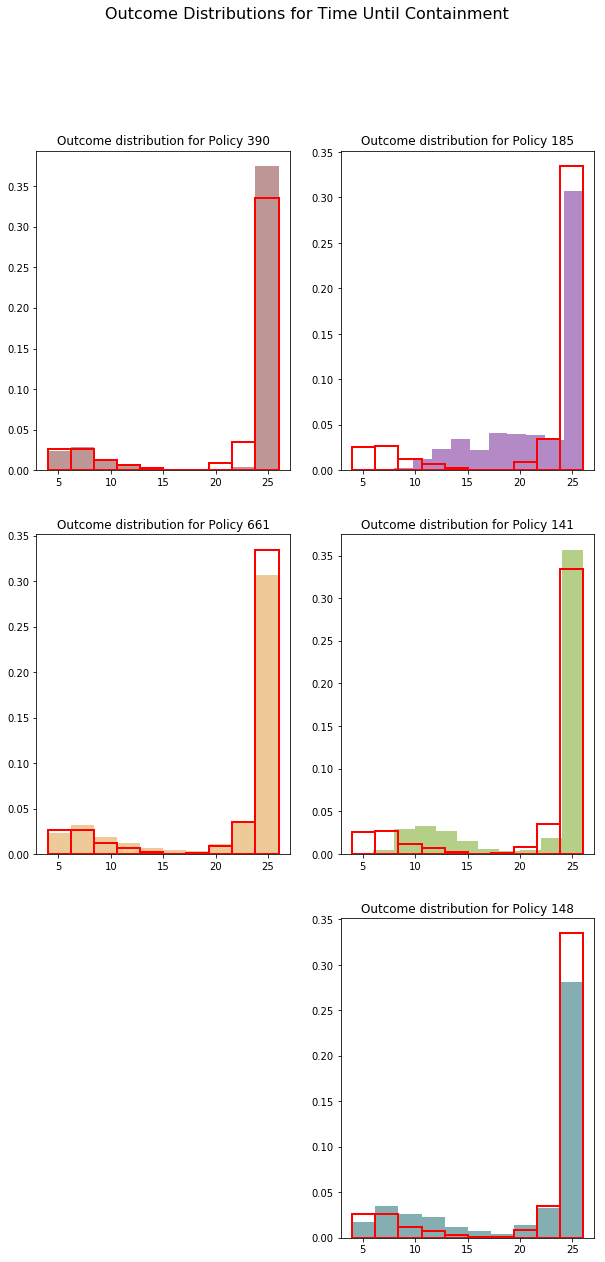

In [23]:
plt.figure(figsize=(10,20))

plt.subplot(321)

plt.hist(policy_390['Time until containment'], density = True, stacked=True, facecolor='#7e2e2e', alpha=0.5, lw=2, label="policy 390")
plt.hist(all_exploitation['Time until containment'], density = True, stacked=True, edgecolor= 'r', fill=False, lw=2,  label="all exploitation")
plt.title("Outcome distribution for Policy 390")

plt.subplot(323)

plt.hist(policy_661['Time until containment'], density = True, stacked=True, facecolor='#DE9733', alpha=0.5, lw=2, label="policy 661")
plt.hist(all_exploitation['Time until containment'], density = True, stacked=True, edgecolor= 'r', fill=False, lw=2,  label="all exploitation")
plt.title("Outcome distribution for Policy 661")




plt.subplot(322)

plt.hist(policy_185['Time until containment'], density = True, stacked=True, facecolor='#69178C',  alpha=0.5, label="policy 185")
plt.hist(all_exploitation['Time until containment'], density = True, stacked=True, edgecolor= 'r', fill=False, lw=2,  label="all exploitation")
plt.title("Outcome distribution for Policy 185")

plt.subplot(324)

plt.hist(policy_141['Time until containment'], density = True, stacked=True, facecolor='#6C9E12', alpha=0.5, lw=2, label="policy 141")
plt.hist(all_exploitation['Time until containment'], density = True, stacked=True, edgecolor= 'r', fill=False, lw=2,  label="all exploitation")
plt.title("Outcome distribution for Policy 141")

plt.subplot(326)

plt.hist(policy_148['Time until containment'], density = True, stacked=True, facecolor='#0D5F67',  alpha=0.5, lw=2, label="policy 148")
plt.hist(all_exploitation['Time until containment'], density = True, stacked=True, edgecolor= 'r', fill=False, lw=2,  label="all exploitation")
plt.title("Outcome distribution for Policy 148")

plt.suptitle('Outcome Distributions for Time Until Containment',size=16)
plt.show()